In [1]:
import os
import torchbnn as bnn
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import copy
import numpy as np
import pandas as pd
import os
import torch
import tqdm
from torch.utils.data import DataLoader
from torchmetrics.regression import R2Score

C:\Users\omondiagbep\Anaconda3\envs\pytorch\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\omondiagbep\Anaconda3\envs\pytorch\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\omondiagbep\Anaconda3\envs\pytorch\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\omondiagbep\Anaconda3\envs\pytorch\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
PREDICT_PROPERTIES=['clay','silt','sand']


def get_spectra_data(train_csv, test_csv=None,mineral=False,target_dataframe=None,over_write_csv=False):


    SPECTRA_COLUMN_STARTING = "nir."
    ID=['labSampleId']

    # check if this is a target and make the target csv to be the same with the global file used for training
    if isinstance(train_csv, list):
        df_source = pd.concat(map(pd.read_csv, train_csv), ignore_index=True)
        #remove spectra signal which is more than 1
        print("removing out of bound spectra from source")

        #subset only the mineral from the lucas data
        if mineral:
            reflectance_out_of_bound = df_source.loc[df_source[df_source[df_source.columns[pd.Series(df_source.columns).str.startswith(SPECTRA_COLUMN_STARTING)]] > 1].dropna(
            how='all', axis=0).index]
            df_source = df_source.loc[set(df_source.index) - set(reflectance_out_of_bound.index)]

            if 'mineral' in df_source.columns:
                df_source=df_source.loc[df_source['mineral'] == 'mineral']


    if target_dataframe is not None:
        df_target = target_dataframe

    if isinstance(test_csv, list) and target_dataframe is None:
        df_target = pd.concat(map(pd.read_csv, test_csv), ignore_index=True)

        # remove spectra signal which is more than 1
        print("removing out of bound spectra from target")

        if mineral:
            reflectance_out_of_bound = df_target.loc[df_target[df_target[df_target.columns[
                pd.Series(df_target.columns).str.startswith(SPECTRA_COLUMN_STARTING)]] > 1].dropna(
                how='all', axis=0).index]

            df_target = df_target.loc[set(df_target.index) - set(reflectance_out_of_bound.index)]

    #common_cols = list(set.intersection(set(df_target), set(df_source)))
    #print(common_cols)

    common_cols = df_source.columns.intersection(df_target.columns)

    # use this list to perform column selection
    df_target_ = df_target[common_cols]
    df_source_ = df_source[common_cols]


    # extract properties for source and target
    df_source_ = df_source_.filter(regex='^(nir.|clay|silt|sand|labSampleId)')
    df_target_ = df_target_.filter(regex='^(nir.|clay|silt|sand|labSampleId)')



    # Define the character to remove
    character_to_remove = 'nir.'

    # Remove the character from column names
    df_source_.columns = df_source_.columns.str.replace(character_to_remove, '')
    df_target_.columns = df_target_.columns.str.replace(character_to_remove, '')


    # Extract column names with numbers greater than the threshold
    source_columns_to_drop = [col for col in df_source_.filter(regex='^(nir.)').columns if int(col) > 4000]
    target_columns_to_drop = [col for col in df_target_.filter(regex='^(nir.)').columns if int(col) > 4000]

    # Drop the selected columns from the DataFrame
    df_source_ = df_source_.drop(columns=source_columns_to_drop)
    df_target_ = df_target_.drop(columns=target_columns_to_drop)


    #split train datasest into train and amin_val_loss
    from sklearn.model_selection import train_test_split
    df_source_train, df_source_val= train_test_split(df_source_,  test_size=0.2, random_state=42)



    df_source_train_= df_source_train.drop(columns=PREDICT_PROPERTIES)
    df_source_val_= df_source_val.drop(columns=PREDICT_PROPERTIES)
    df_target__= df_target_.drop(columns=PREDICT_PROPERTIES)

    df_source_spectral_train = get_spectra(df_source_train_)

    df_source_spectral_val = get_spectra(df_source_val_)
    print(len(df_source_spectral_train))
    print(len(df_source_spectral_val))


    df_target_spectral = get_spectra(df_target__)
    print(len(df_target_spectral))

    #this is use to trim the incoming data when we upload the model to ur api
    if over_write_csv:
        pd.DataFrame(df_source_spectral_train).head(2).to_csv("../Data/ph_source_file.csv", index=False)

    df_source_spectral_train=df_source_spectral_train.to_numpy()
    df_source_spectral_val=df_source_spectral_val.to_numpy()
    df_target_spectral=df_target_spectral.to_numpy()

    print(df_source_spectral_train.shape)

    for i in range(len(PREDICT_PROPERTIES)):
        if PREDICT_PROPERTIES[i] not in df_source_train.columns:
            df_source_train[PREDICT_PROPERTIES[i]] =df_source_train[PREDICT_PROPERTIES[i]]

        if PREDICT_PROPERTIES[i] not in df_source_val.columns:
            df_source_val[PREDICT_PROPERTIES[i]] =df_source_val[PREDICT_PROPERTIES[i]]

        if PREDICT_PROPERTIES[i] not in df_target_.columns and PREDICT_PROPERTIES[i] in  df_target:
            df_target_[PREDICT_PROPERTIES[i]] =df_target[PREDICT_PROPERTIES[i]]

    # remove the 2500 column in the USA/NZ data
    #df_source = df_source.drop([SPECTRA_COLUMN_STARTING, SPECTRA_COLUMN_STARTING + '2500'], axis=1, errors='ignore')
    #df_target = df_target.drop([SPECTRA_COLUMN_STARTING, SPECTRA_COLUMN_STARTING + '2500'], axis=1, errors='ignore')

    return df_source_train, df_source_val,df_target_, df_source_spectral_train,df_source_spectral_val, df_target_spectral


def get_spectra(df):

    filter_col = [col for col in df.columns]

    data = df[filter_col]

    data=data.iloc[:, 2::10]


    return data



In [3]:
import pandas as pd
#change to match your the path where you have the cal and cal dataset
GLOBAL_CSV=[ "C:/Projects/SmapProjects/SpectraData2023/mir_texture_cali.csv"]
#df_sources, df_targets, df_sources_spectral, df_targets_spectral=get_spectra_data(train_csv=GLOBAL_CSV,target_dataframe=df)

TARGET_CSV=[ "C:/Projects/SmapProjects/SpectraData2023/mir_texture_val.csv"]
df_source_train, df_source_val,df_target, df_source_spectral_train, df_source_spectral_val,df_target_spectral=get_spectra_data(train_csv=GLOBAL_CSV,test_csv=TARGET_CSV,over_write_csv=True)


X_train_raw = df_source_spectral_train#.reshape(df_source_spectral_train.shape[0], df_source_spectral_train.shape[1], 1)
#X_train=np.log(1 / X_train)
y_train = np.array(df_source_train[PREDICT_PROPERTIES].values)

X_val_raw = df_source_spectral_val#.reshape(df_source_spectral_val.shape[0], df_source_spectral_val.shape[1], 1)
y_val= np.array(df_source_val[PREDICT_PROPERTIES].values)


X_test_raw =df_target_spectral#.reshape(df_target_spectral.shape[0], df_target_spectral.shape[1], 1)
y_test =df_target[PREDICT_PROPERTIES].values

removing out of bound spectra from source
removing out of bound spectra from target
2412
604
1005
(2412, 340)


In [4]:
# Standardizing data
scaler = StandardScaler()
scaler.fit(X_train_raw)
scaler.fit(X_val_raw)
X_val = scaler.transform(X_val_raw)
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [5]:
# Convert to 2D PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 3)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32).reshape(-1, 3)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 3)

In [195]:
def evaluate(model,test_x,test,type="mae"):
    df =evaluate_soil_texture(model,test_x,sample_size = 100)

    result_clay= pd.DataFrame(columns=['clay_upper', 'clay_lower','clay_pred', 'clay_obs'])
    result_silt= pd.DataFrame(columns=['silt_upper', 'silt_upper','silt_pred', 'silt_obs'])
    result_sand= pd.DataFrame(columns=['sand_upper', 'sand_lower','sand_pred', 'sand_obs'])

    result_clay['clay_pred'] = df['clay_pred']
    result_clay['clay_lower'] =df['clay_lower']
    result_clay['clay_upper'] =df['clay_upper']
    result_clay['clay_obs']=test[:,0]

    result_silt['silt_pred'] = df['silt_pred']
    result_silt['silt_upper'] = df['silt_upper']
    result_silt['silt_upper'] = df['silt_upper']
    result_silt['silt_obs']=test[:,1]

    result_sand['sand_pred'] = df['sand_pred']
    result_sand['sand_upper'] = df['sand_upper']
    result_sand['sand_lower'] = df['sand_lower']
    result_sand['sand_obs'] = test[:,2]

    if type=="mae":
        result = [mean_absolute_error(test[:,0],result_clay['clay_pred']),
                  mean_absolute_error(test[:,1],result_silt['silt_pred']),
                  mean_absolute_error(test[:,2],result_sand['sand_pred'])]
    elif type=="r2":
        result = [r2_score(test[:,0],result_clay['clay_pred']),
                  r2_score(test[:,1],result_silt['silt_pred']),
                  r2_score(test[:,2],result_sand['sand_pred'])]
    elif type=="mse":
        result = [mean_squared_error(test[:,0],result_clay['clay_pred']),
                  mean_squared_error(test[:,1],result_silt['silt_pred']),
                  mean_squared_error(test[:,2],result_sand['sand_pred'])]

    elif type=="rmse":
        result=[ np.sqrt(mean_squared_error(test[:,0],result_clay['clay_pred'])),
                   np.sqrt(mean_squared_error(test[:,1],result_silt['silt_pred'])),
                   np.sqrt(mean_squared_error(test[:,2],result_sand['sand_pred']))]

    return result

#evaluate model
from scipy import stats

def evaluate_soil_texture(model,
                         test,
                        sample_size = 100,
                        std_multiplier = 2):

    df = pd.DataFrame(columns=['clay_lower','clay_upper','clay_pred',
                               'silt_lower','silt_upper','silt_pred',
                               'sand_lower','sand_upper','sand_pred'])

    with torch.no_grad():
        model.eval()
        scaler = StandardScaler()
        scaler.fit(test)
        predictions=[]
        test = scaler.transform(test)
        test = torch.tensor(test, dtype=torch.float32)
        for _ in range(sample_size):
            output = model(test)  # Replace 'input_data' with your test input
            predictions.append(output.detach().numpy())

        #predictions = torch.tensor(predictions)

        normalized_pred = []
        for pred in predictions:
            abs_pred = np.abs(pred)
            normalized_pred.append(abs_pred / np.sum(abs_pred, axis=-1, keepdims=True) * 100)

        predictions = np.stack(normalized_pred)

        prediction_mean = np.mean(predictions, axis=0)
        prediction_std = np.std(predictions, axis=0)


        # Calculate lower and upper bounds for the prediction interval (e.g., 95% interval)
        lower_bound = prediction_mean - 1.645 * prediction_std
        upper_bound = prediction_mean + 1.645 * prediction_std

        for i in range(0,len(prediction_mean[:,0])):

            #get the first element since we ar predicting just one at a time
            mean_clay = prediction_mean[i,0]
            mean_sand = prediction_mean[i,2]
            mean_silt = prediction_mean[i,1]
            lower_clay = lower_bound[i,0]
            upper_clay = upper_bound[i,0]
            lower_silt = lower_bound[i,1]
            upper_silt = upper_bound[i,1]
            lower_sand = lower_bound[i,2]
            upper_sand = upper_bound[i,2]

            row = {'clay_upper':upper_clay,'clay_lower':lower_clay,'clay_pred':mean_clay,
                   'sand_upper':upper_sand,'sand_lower':lower_sand,'sand_pred':mean_sand,
                   'silt_upper':upper_silt,'silt_lower':lower_silt,'silt_pred':mean_silt}
            df.loc[i] = row

    return df

## 2. Define Model

In [119]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal

class BayesianCNNs(nn.Module):
    def __init__(self,num_feature: int,weight_std=0.001,bias_std=9.5):
        super(BayesianCNNs, self).__init__()
        #self.fc1 = nn.Linear(340, 256)  # Adjust the input size based on your input size
        # self.fc1 = nn.Linear(num_feature, 256)
        # self.fc2 = nn.Linear(256, 128)
        # self.fc3 = nn.Linear(128, 32)
        # self.fc5 = nn.Linear(32, 1)  # Output layer for regression
        self.fc1 = nn.Linear(num_feature, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 1)  # Output layer for regression

        # Define parameters for weight and bias distributions for the linear layer
        self.weight_mu = nn.Parameter(torch.Tensor(1, 32))
        self.weight_rho = nn.Parameter(torch.Tensor(1, 32))
        self.bias_mu = nn.Parameter(torch.Tensor(1))
        self.bias_rho = nn.Parameter(torch.Tensor(1))
        self.weight_std=weight_std
        self.bias_std=bias_std

        # Initialize parameters
        self.reset_parameters()

    def reset_parameters(self):
        # Initialize weight means close to zero and standard deviations to be small
        nn.init.normal_(self.weight_mu, mean=0.0002, std=self.weight_std)
        nn.init.normal_(self.weight_rho, mean=0.003, std=self.bias_std)

        # Initialize bias means close to zero and standard deviations to be small
        nn.init.normal_(self.bias_mu, mean=0.0003, std=self.weight_std)
        nn.init.normal_(self.bias_rho, mean=0.004, std=self.bias_std)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = F.rrelu(self.fc1(x))
        x = F.rrelu(self.fc2(x))
        x = F.rrelu(self.fc3(x))

        # Re-parameterization trick for sampling weights
        weight_epsilon = Normal(0, 1).sample(self.weight_mu.size())
        weight_sigma = torch.log(1 + torch.exp(self.weight_rho))
        weight = self.weight_mu + weight_sigma * weight_epsilon

        bias_epsilon = Normal(0, 1).sample(self.bias_mu.size())
        bias_sigma = torch.log(1 + torch.exp(self.bias_rho))
        bias = self.bias_mu + bias_sigma * bias_epsilon

        # Enforce non-negativity on weights and biases
        weight = torch.clamp(weight, min=0)
        bias = torch.clamp(bias, min=0)

        # Linear layer operation
        output = F.linear(x, weight, bias)
        return output

# Define a Bayesian CNN model
class BayesianCNN(nn.Module):
    def __init__(self, num_feature: int, dims=[256, 512, 128, 32], weight_std=0.001, bias_std=9.5):
        super(BayesianCNN, self).__init__()

        # Define the fully connected layers based on the specified dimensions
        self.fc_layers = nn.ModuleList()
        in_dim = num_feature
        for out_dim in dims:
            self.fc_layers.append(nn.Linear(in_dim, out_dim))
            in_dim = out_dim

        self.fc_out = nn.Linear(in_dim, 3)  # Output layer for soil, clay and silt

        # Update the dimensions of weight_mu and weight_rho to match the output dimension
        self.weight_dim = out_dim
        self.weight_mu = nn.Parameter(torch.Tensor(3, self.weight_dim))
        self.weight_rho = nn.Parameter(torch.Tensor(3, self.weight_dim))

        self.bias_mu = nn.Parameter(torch.Tensor(3))
        self.bias_rho = nn.Parameter(torch.Tensor(3))
        self.weight_std = weight_std
        self.bias_std = bias_std

        # Initialize parameters
        self.reset_parameters()

    def reset_parameters(self):
        # Initialize weight means close to zero and standard deviations to be small
        nn.init.normal_(self.weight_mu, mean=0.0002, std=self.weight_std)
        nn.init.normal_(self.weight_rho, mean=0.003, std=self.bias_std)

        # Initialize bias means close to zero and standard deviations to be small
        nn.init.normal_(self.bias_mu, mean=0.0003, std=self.weight_std)
        nn.init.normal_(self.bias_rho, mean=0.004, std=self.bias_std)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input

        # Pass through fully connected layers with specified dimensions
        for fc_layer in self.fc_layers:
            x = F.rrelu(fc_layer(x))

        # Re-parameterization trick for sampling weights
        weight_epsilon = Normal(0, 1).sample(self.weight_mu.size())
        weight_sigma = torch.log(1 + torch.exp(self.weight_rho))
        weight = self.weight_mu + weight_sigma * weight_epsilon

        bias_epsilon = Normal(0, 1).sample(self.bias_mu.size())
        bias_sigma = torch.log(1 + torch.exp(self.bias_rho))
        bias = self.bias_mu + bias_sigma * bias_epsilon

        # Enforce non-negativity on weights and biases
        weight = torch.clamp(weight, min=0)
        bias = torch.clamp(bias, min=0)

        # Final linear layer operation
        output = F.linear(x, weight, bias)
        return output

In [8]:
train = torch.utils.data.TensorDataset(X_train,y_train)
train_dataloader = DataLoader(train, batch_size=16)

val= torch.utils.data.TensorDataset(X_val,y_val)
val_dataloader = DataLoader(val, batch_size=16)

test= torch.utils.data.TensorDataset(X_test,y_test)
test_dataloader = DataLoader(test, batch_size=16)


In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

#Manually compute the L1 loss over all model parameters:
def l1_penalty(model):
    l1_loss = 0.0
    for param in model.parameters():
        l1_loss += torch.abs(param).sum()
    return l1_loss

def train_epoch(train,val,model,loss_fn,optimizer,batch_size,n_epochs):

    train_dataloader = DataLoader(train, batch_size=batch_size)
    model.train()
    for epoch in range(n_epochs):
        for inputs, targets in train_dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()

        # Print the training loss for this epoch
        print(f"Epoch [{epoch+1}/{n_epochs}] Loss: {loss.item():.5f}")
        #evaluate accuracy at end of each epoch
        test_epoch(val,model, loss_fn ,optimizer,batch_size,n_epochs)



def test_epoch(val,model,loss_fn,optimizer,batch_size,n_epochs):
    val_dataloader = DataLoader(val, batch_size=batch_size)
    val_loss=0
    model.eval()
    for inputs, targets in val_dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            val_loss += loss.item()
            loss.backward()
            optimizer.step()

        # Print the training loss for this epoch
    avg_val_loss = val_loss / len(inputs)
    print(f"Epoch [{n_epochs+1}/{n_epochs}] Val Loss: {loss.item():.5f}")

    return avg_val_loss

def get_metrics(test,y_test,model):
    loss_fn = nn.MSELoss()
    model.eval()
    y_pred = model(test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    rmse= np.sqrt(mse)
    test_result= evaluate_soil_texture(model,test)
    test_result["clay_obs"] = y_test[:,0:1].numpy().flatten()
    test_result["silt_obs"] = y_test[:,1:2].numpy().flatten()
    test_result["sand_obs"] = y_test[:,2:3].numpy().flatten()
    clay_pcip = calculate_pcip(test_result["clay_obs"], test_result['clay_lower'], test_result['clay_upper'])
    silt_pcip = calculate_pcip(test_result["silt_obs"], test_result['silt_lower'], test_result['silt_upper'])
    sand_pcip = calculate_pcip(test_result["sand_obs"], test_result['sand_lower'], test_result['sand_upper'])

    clay_r2=r2_score(y_test[:,0:1].numpy().flatten(),test_result['clay_pred'])
    silt_r2=r2_score(y_test[:,1:2].numpy().flatten(),test_result['silt_pred'])
    sand_r2=r2_score(y_test[:,2:3].numpy().flatten(),test_result['sand_pred'])


    print(f'MSE: {mse:.4f},RMSE: {rmse:.4f}, clay_r2: {clay_r2:.4f},silt_r2: {silt_r2:.4f},sand_r2: {sand_r2:.4f}, clay_pcip: {clay_pcip:.2f},silt_pcip: {silt_pcip:.2f},sand_pcip: {sand_pcip:.2f}')
    return [mse,rmse,clay_pcip,silt_pcip,sand_pcip,clay_r2,silt_r2,sand_r2]

def calculate_pcip(y_true, lower_bounds, upper_bounds):
    num_samples = len(y_true)
    num_covering_intervals = np.sum((lower_bounds <= y_true) & (y_true <= upper_bounds))
    pcip = (num_covering_intervals / num_samples) * 100
    return pcip

Using cpu device


In [126]:
from ray.tune.search.optuna import OptunaSearch
import torch
import torch.optim as optim
import ray
from ray.air import session, Checkpoint
from ray.tune.schedulers import PopulationBasedTraining, HyperBandForBOHB
from ray.tune.schedulers import AsyncHyperBandScheduler
from enum import Enum
loss_fn = nn.MSELoss()


class Optimiser(str, Enum):
    Adams = "Adams"
    SGD ="SGD"
    Adadelta = "Adadelta"
    Adagrad = "Adagrad"
    Adamax = "Adamax"
    Nadam = "Nadam"
    Ftrl = "Ftrl"
    RMSprop="RMSprop"
    LBFGS ="LBFGS"
    #LBFGS ="LBFGS"
    def __str__(self):
        return self.value

 # set your desired L1 regularization strength
def objective(config):  # ①

    #dataset
    train = torch.utils.data.TensorDataset(X_train,y_train)

    val= torch.utils.data.TensorDataset(X_val,y_val)

    criterion=nn.MSELoss()

    dims = config["dims"]  # You can change this to any number you want



    model = BayesianCNN(num_feature=X_train.shape[1],dims=config["dims"],
                           weight_std=config["weight_std"],
                          bias_std=config["bias_std"]).to("cpu")   # Create a PyTorch conv net

    if config["optimiser"] == Optimiser.RMSprop:
        optimizer = torch.optim.RMSprop(model.parameters(), momentum=config["opt_momentum"], lr=config["lr"])
    elif config["optimiser"] == Optimiser.LBFGS:
        optimizer = torch.optim.LBFGS(model.parameters(),  lr=config["lr"])
    elif config["optimiser"] == Optimiser.Adams:
        optimizer = torch.optim.Adam(model.parameters(),  lr=config["lr"])
    elif config["optimiser"] == Optimiser.SGD:
        optimizer = torch.optim.SGD(model.parameters(),  lr=config["lr"],momentum=config["opt_momentum"])
    elif config["optimiser"] == Optimiser.Nadam:
        optimizer = torch.optim.NAdam(model.parameters(),  lr=config["lr"],momentum_decay=config["opt_momentum"])

    checkpoint = session.get_checkpoint()

    if checkpoint:
        checkpoint_state = checkpoint.to_dict()
        with checkpoint.as_directory() as dir_path:
            print("test")
            model_state, optimizer_state = torch.load(os.path.join(dir_path, "checkpoint.pt"))

            # Load optimizer state (needed since we're using momentum),
            # then set the `lr` and `momentum` according to the config.
            optimizer.load_state_dict(optimizer_state)
            model.load_state_dict(model_state)
        for param_group in optimizer.param_groups:
            if "lr" in config:
                param_group["lr"] = config["lr"]
            if "opt_momentum" in config:
                param_group["opt_momentum"] = config["opt_momentum"]

    while True:

        train_epoch(train,val,model, criterion ,optimizer,config["batch_size"],config["epochs"])  # Train the model


        os.makedirs("model", exist_ok=True)
        torch.save(
            (model.state_dict(), optimizer.state_dict()), "model/checkpoint.pt")


        mse,rmse,clay_pcip,silt_pcip,sand_pcip,clay_r2,silt_r2,sand_r2 = get_metrics(X_test,y_test,model)  # Compute test accuracy
        score_avg = (clay_pcip+silt_pcip+sand_pcip+(clay_r2*100)+(silt_r2*100)+(sand_r2*100))/6

        checkpoint = Checkpoint.from_directory("model")

        session.report({"score_avg":score_avg,"done": rmse < 0.25,"mse": mse, "rmse": rmse,"clay_r2": clay_r2,"sand_r2": sand_r2,"silt_r2": silt_r2, "clay_pcip": clay_pcip,"sand_pcip": sand_pcip,"silt_pcip": silt_pcip},checkpoint=checkpoint)  # Report to Tune

##### RUN  ##############
import ray
from ray.tune.search.hyperopt import HyperOptSearch
from ray.tune.search import ConcurrencyLimiter
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.tune.schedulers.pb2 import PB2
from ray.tune import tune
import random

ray.shutdown()
# Your original list of dimensions
original_dims = [512, 256,  128, 64, 32,  16,  8, 512,256,128,64,28]
# List of optimizer names
optimizer_names = ["Adams", "SGD","Nadam"]
optimizer_names = ["Adams", "Nadam"]
ray.init(num_cpus=12, num_gpus=0,_temp_dir="/ray") # assign the total # of cpus and gpus, make sure you have ray.init in the beginning and ray.shutdown at the end
sched = AsyncHyperBandScheduler(  time_attr="training_iteration",
    reduction_factor=2,
    metric='rmse',
    mode='min')  # set a scheduler

perturbation_interval = 10
#use population based training
scheduler =PopulationBasedTraining(
       time_attr="training_iteration",
    perturbation_interval=perturbation_interval,
    metric="rmse",
    mode="min",
    quantile_fraction=0.25,  # copy bottom % with top %
    #hyperparam_mutation - for pbt
    hyperparam_mutations={
        # distribution for resampling
        "lr": [0.0001, 0.1],
        "momentum": [0.009,0.01],
        "opt_momentum": [0.009,0.01],
    }
)
algo =OptunaSearch(metric=["rmse","pcip"], mode=["min","max"])# HyperOptSearch() # if you want to use the Bayesian optimization, import BayesOptSearch instead
algo = ConcurrencyLimiter(algo, max_concurrent=12)
scheduler = HyperBandForBOHB(
    time_attr="training_iteration",
    max_t=30,
    #metric="rmse",
    #mode='min',
    reduction_factor=0.25,
    stop_last_trials=False,
)
scheduler = PB2(
    time_attr="training_iteration",
    perturbation_interval=perturbation_interval,
    metric="score_avg",
    mode="max",
    quantile_fraction=0.4,  # copy bottom % with top %
    #hyperparam_mutation - for pbt
    hyperparam_bounds={
        # distribution for resampling
        "lr": [0.00001, 0.1],
        "momentum": [0.009,0.01],
        "opt_momentum": [0.009,0.01],
    },
)
analysis = tune.run(
        objective,   # the core training/testing of your model
        #storage_path=os.getcwd(), # for saving the log files
        name="pbt_texture_exp", # name for the result directory
        #resume="REMOTE",
        #metric="rmse",
        #resume="PROMPT",
        #mode='min',
        #search_alg=algo,
        scheduler=scheduler,
        stop={
                "training_iteration": 20,
                "done": True,
                "rmse": 0.05,
        },
        resources_per_trial={
                "cpu": 1,
                "gpu": 0
         },
        num_samples=30, # 50 trials
        progress_reporter=ray.tune.JupyterNotebookReporter(metric="score_avg",overwrite=True,max_report_frequency=7),
        config={

               "lr": ray.tune.loguniform(0.00001, 0.1),
                "l1_coef": ray.tune.loguniform(0.00001, 0.3),
                  #"pred_interval_constant":ray.tune.loguniform(0.28, 12.05),
                 "momentum": ray.tune.loguniform(0.009,0.01),
                 "weight_std": ray.tune.loguniform(0.0001,10.02),
                "dims": ray.tune.sample_from(lambda spec: random.choices(original_dims,k=random.randint(2, 7))),
                 "bias_std": ray.tune.loguniform(0.01, 17.7),
                 "batch_size": ray.tune.randint(2,128),
                 "epochs":ray.tune.randint(2,1000),
                "optimiser": ray.tune.sample_from(lambda spec: random.choice(optimizer_names)),
                 "checkpoint_interval": perturbation_interval
        })

2023-10-01 16:19:55,903	INFO tune.py:657 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
2023-10-01 16:19:56,193	WARNING callback.py:144 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`
2023-10-01 16:20:03,776	WARNING worker.py:2037 -- Warning: The actor ImplicitFunc is very large (10 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
(pid=46152) C:\Users\omondiagbep\Anaconda3\envs\pytorch\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
(pid=46152) C:\Users\omondiagbep\Anaconda3\envs\pytorch\lib\

(objective pid=50060) Epoch [1/193] Loss: 571.10712
(objective pid=50060) Epoch [194/193] Val Loss: 494.42886
(objective pid=4988) Epoch [1/543] Loss: 358.98950 [repeated 13x across cluster]
(objective pid=50060) Epoch [194/193] Val Loss: 466.57721 [repeated 13x across cluster]
(objective pid=50060) 
(objective pid=28728) Epoch [5/519] Loss: 130.84824 [repeated 25x across cluster]
(objective pid=45640) Epoch [510/509] Val Loss: 1368.02832 [repeated 28x across cluster]
(objective pid=4988) Epoch [9/543] Loss: 38.23963 [repeated 25x across cluster]
(objective pid=4988) Epoch [544/543] Val Loss: 74.08536 [repeated 22x across cluster]
(objective pid=12164) Epoch [7/541] Loss: 80.10419 [repeated 28x across cluster]
(objective pid=50304) Epoch [719/718] Val Loss: 50.72427 [repeated 29x across cluster]
(objective pid=32264) Epoch [3/775] Loss: 810.43658 [repeated 25x across cluster]
(objective pid=27160) Epoch [160/159] Val Loss: 86.54642 [repeated 26x across cluster]
(objective pid=47768) Ep

Trial name,clay_pcip,clay_r2,mse,rmse,sand_pcip,sand_r2,score_avg,should_checkpoint,silt_pcip,silt_r2
objective_6514c_00005,38.3085,0.883801,55.4149,7.44412,34.3284,0.890639,60.2193,True,29.2537,0.819815


In [175]:
best_trial = analysis.get_best_trial("score_avg", "max", "all")

print(f"Best trial config: {best_trial.config}")
print(f"Best trial final validation mse: {best_trial.last_result['mse']}")
print(f"Best trial final validation r2: {best_trial.last_result['clay_r2']}")
print(f"Best trial final validation rmse: {best_trial.last_result['clay_pcip']}")
print(f"Best trial final validation r2: {best_trial.last_result['silt_r2']}")
print(f"Best trial final validation rmse: {best_trial.last_result['silt_pcip']}")
print(f"Best trial final validation r2: {best_trial.last_result['sand_r2']}")
print(f"Best trial final validation rmse: {best_trial.last_result['sand_pcip']}")
print(f"Best trial final validation score_avg: {best_trial.last_result['score_avg']}")
best_checkpoint = best_trial.checkpoint.to_air_checkpoint()

Best trial config: {'lr': 1.6299216435045153e-05, 'l1_coef': 0.012296389253618025, 'momentum': 0.00942476337552735, 'weight_std': 0.028273830452384557, 'dims': [512, 28, 64], 'bias_std': 9.685476870226465, 'batch_size': 70, 'epochs': 602, 'optimiser': 'Adams', 'checkpoint_interval': 10, 'opt_momentum': 0.009633445894788139}
Best trial final validation mse: 250.9261016845703
Best trial final validation r2: 0.8208657645487385
Best trial final validation rmse: 92.7363184079602
Best trial final validation r2: 0.746939749450155
Best trial final validation rmse: 95.72139303482588
Best trial final validation r2: 0.8492732132160699
Best trial final validation rmse: 84.87562189054727
Best trial final validation score_avg: 85.84020100913828


In [142]:
ps=best_trial
import pandas as pd

In [176]:
gpus_per_trial = 2
best_trained_model=BayesianCNN(num_feature=X_train.shape[1],dims=best_trial.config["dims"],
                           weight_std=best_trial.config["weight_std"],
                          bias_std=best_trial.config["bias_std"])

device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
    if gpus_per_trial > 1:
        best_trained_model = nn.DataParallel(best_trained_model)
best_trained_model.to(device)
with best_checkpoint.as_directory() as dir_path:
    print(dir_path)
    model_state, optimizer_state = torch.load(os.path.join(dir_path, "checkpoint.pt"))
    best_trained_model.load_state_dict(model_state)
best_checkpoint_data = best_checkpoint.to_dict()
#print(best_checkpoint_data)


C:\Users\omondiagbep\ray_results\pbt_texture_exp\objective_6514c_00024_24_batch_size=70,bias_std=9.6855,epochs=602,l1_coef=0.0123,lr=0.0000,momentum=0.0094,weight_std=0.0283_2023-10-01_16-21-12\checkpoint_000000


In [158]:
def train_func(model,optimizer_=None,n_epochs = 1000,momentum=0.0009,batch_size = 16,lr=0.0001,momentum_decay=0.0009):
    loss_fn = nn.MSELoss()  # mean square error

    if optimizer_ is None:
        optimizer = torch.optim.Adam(model.parameters(),  lr=lr)
    if optimizer_ == Optimiser.RMSprop:
        optimizer = torch.optim.RMSprop(model.parameters(), momentum=momentum, lr=lr)
    elif optimizer_ == Optimiser.LBFGS:
        optimizer = torch.optim.LBFGS(model.parameters(),  lr=lr)
    elif optimizer_ == Optimiser.Adams:
        optimizer = torch.optim.Adam(model.parameters(),  lr=lr)
    elif optimizer_ == Optimiser.SGD:
        optimizer = torch.optim.SGD(model.parameters(),  lr=lr,momentum=momentum)
    elif optimizer_ == Optimiser.Nadam:
        optimizer = torch.optim.NAdam(model.parameters(),  lr=lr,momentum_decay=momentum_decay)


    # Hold the best model
    best_mse = np.inf # init to infinity
    criterion =nn.MSELoss()

    history = []
    epochs_no_improve = 0

    early_stop=False
    n_epochs_stop = 40
    min_val_loss=float('inf')
    best_clay_r2 = 0.0000
    best_sand_r2 = 0.0000
    best_silt_r2 = 0.0000
    best_clay_pcip = 0.0000
    best_sand_pcip = 0.0000
    best_silt_pcip = 0.0000
    train = torch.utils.data.TensorDataset(X_train,y_train)
    val = torch.utils.data.TensorDataset(X_val,y_val)
    train_dataloader = DataLoader(train, batch_size=batch_size)
    val_dataloader = DataLoader(val, batch_size=batch_size)
    for epoch in range(n_epochs):
        model.train()
        train_loss =0
        val_loss=0

        for inputs, targets in train_dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

        # Print the training loss for this epoch
        print(f"Epoch [{epoch+1}/{n_epochs}] Loss: {loss.item():.5f}")

        for inputs, targets in val_dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            loss.backward()
            optimizer.step()

        # Print the training loss for this epoch
        avg_val_loss = val_loss / len(inputs)
        print(f"Epoch [{epoch+1}/{n_epochs}] Val Loss: {loss.item():.5f}")

        #at the start
        if avg_val_loss < min_val_loss:
            epochs_no_improve = 0
            min_val_loss = avg_val_loss
            print("restarting counter")
            print(epochs_no_improve)
        else:
            epochs_no_improve += 1
            print("increasing counter")
            print(epochs_no_improve)

        if epochs_no_improve == n_epochs_stop:
            print('Early stopping!')
            early_stop = True
            break
        # evaluate accuracy at end of each epoch
        model.eval()
        mse,rmse,clay_pcip,silt_pcip,sand_pcip,clay_r2,silt_r2,sand_r2 = get_metrics(X_test,y_test,model)
        print(f'clay_r2: {clay_r2:.4f}')
        print(f'clay_pcip: {clay_pcip:.4f}')
        y_pred = model(X_test)

        mse = loss_fn(y_pred, y_test)
        mse = float(mse)
        rmse= np.sqrt(mse)
        print(f'RMSE: {rmse:.4f}')
        history.append(rmse)
        if rmse < best_mse:
            best_mse = rmse
            print("save rmse state")
            modelrmse_state_dict = model.state_dict()
        if clay_r2 > best_clay_r2 :
            best_clay_r2 = clay_r2
        if sand_r2 > best_sand_r2 :
            best_sand_r2 = sand_r2
        if silt_r2 > best_silt_r2 :
            best_silt_r2 = silt_r2

        if clay_pcip > best_clay_pcip :
            best_clay_pcip = clay_pcip
            print("save pcip state")
            modelpcip_state_dict = model.state_dict()
        if sand_pcip > best_sand_pcip :
            print("save pcip state")
            best_sand_pcip = sand_pcip
            modelpcip_state_dict = model.state_dict()
        if silt_pcip > best_silt_pcip :
            print("save pcip state")
            best_silt_pcip = silt_pcip
            modelpcip_state_dict = model.state_dict()

        if early_stop:
            print('Training stopped early.')


        print(f'Best RMSE so far: {best_mse:.4f}')
        print(f'Best clay_r2 so far: {best_clay_r2:.4f}')
        print(f'Best sand_r2 so far: {best_sand_r2:.4f}')
        print(f'Best silt_r2 so far: {best_silt_r2:.4f}')
        print(f'Best clay_pcip so far: {best_clay_pcip:.4f}')
        print(f'Best sand_pcip so far: {best_sand_pcip:.4f}')
        print(f'Best silt_pcip so far: {best_silt_pcip:.4f}')

    modelrmse_state_dict.update(modelpcip_state_dict)

    # Load the updated state_dict back into model
    model.load_state_dict(modelrmse_state_dict)
    print("RMSE: %.2f" % best_mse)
    plt.plot(history)
    plt.show()
    return model,history,best_mse

## Best architecture found


In [177]:
#fine tune if neededs

model = BayesianCNN(num_feature=X_train.shape[1],weight_std=4.7621,bias_std=16.738).to("cpu")

Epoch [1/1000] Loss: 889.44965
Epoch [1/1000] Val Loss: 972.82825
restarting counter
0
MSE: 858.8217,RMSE: 29.3057, clay_r2: -0.6186,silt_r2: -1.0949,sand_r2: 0.0084, clay_pcip: 32.44,silt_pcip: 23.58,sand_pcip: 21.19
clay_r2: -0.6186
clay_pcip: 32.4378
RMSE: 31.1636
save rmse state
save pcip state
save pcip state
save pcip state
Best RMSE so far: 31.1636
Best clay_r2 so far: 0.0000
Best sand_r2 so far: 0.0084
Best silt_r2 so far: 0.0000
Best clay_pcip so far: 32.4378
Best sand_pcip so far: 21.1940
Best silt_pcip so far: 23.5821
Epoch [2/1000] Loss: 511.13162
Epoch [2/1000] Val Loss: 630.96252
restarting counter
0
MSE: 650.5995,RMSE: 25.5069, clay_r2: -0.0779,silt_r2: -0.4060,sand_r2: 0.1123, clay_pcip: 61.59,silt_pcip: 42.49,sand_pcip: 31.54
clay_r2: -0.0779
clay_pcip: 61.5920
RMSE: 23.7238
save rmse state
save pcip state
save pcip state
save pcip state
Best RMSE so far: 23.7238
Best clay_r2 so far: 0.0000
Best sand_r2 so far: 0.1123
Best silt_r2 so far: 0.0000
Best clay_pcip so far: 

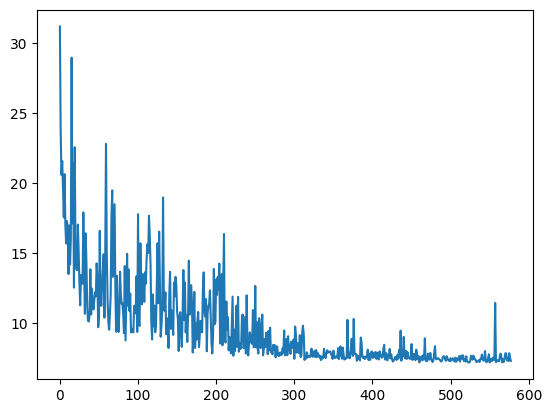

In [178]:
model,history,best_mse =train_func(model,lr=0.0000589,
                                   n_epochs=1000,batch_size=66,optimizer_="Nadam")


In [26]:
# #freeze all layer expect last two (uncertainity and predction layer)
# for name, param in model.named_parameters():
#     print(name)
#     if name.startswith('uncertainty_layer') or name.startswith('output_layer'):
#         param.requires_grad = True
#     else:
#         param.requires_grad = False
# Access the uncertainty_layer
# uncertainty_layer = model.uncertainty_layer
#
# # Modify the prior_sigma
# new_prior_sigma = 0.001  # Replace with your an higher value
# model.uncertainty_layer.prior_sigma = new_prior_sigma



layers.0.fc.weight
layers.0.fc.bias
layers.2.weight
layers.2.bias
layers.3.fc.weight
layers.3.fc.bias
layers.5.weight
layers.5.bias
layers.6.fc.weight
layers.6.fc.bias
layers.8.weight
layers.8.bias
layers.9.fc.weight
layers.9.fc.bias
layers.11.weight
layers.11.bias
output_layer.weight
output_layer.bias
uncertainty_layer.weight_mu
uncertainty_layer.weight_log_sigma
uncertainty_layer.bias_mu
uncertainty_layer.bias_log_sigma


In [363]:
# # Initialize optimizer with different learning rates based on layer names
# optimizer = torch.optim.Adam([
#     {'params': param, 'lr': 0.01}  # Lower learning rate for uncertainty layers
#     if 'uncertainty' in name else
#     {'params': param, 'lr': 0.0001}  # Higher learning rate for other layers
#     for name, param in model.named_parameters()
# ])

In [78]:
best_trained_model

BayesianCNN(
  (fc1): Linear(in_features=340, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=3, bias=True)
)

In [199]:
#save model
best_model_name = f'mir_soil_texture_model-1.0.1.pt'
torch.save(best_trained_model.state_dict(),os.path.join("../../model-store/",best_model_name))

In [188]:
best_model_name = f'mir_soil_texture_model-1.0.1.pt'
model=torch.load(os.path.join("../../model-store/",best_model_name))

In [204]:
best_trained_model

BayesianCNN(
  (fc_layers): ModuleList(
    (0): Linear(in_features=340, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=28, bias=True)
    (2): Linear(in_features=28, out_features=64, bias=True)
  )
  (fc_out): Linear(in_features=64, out_features=3, bias=True)
)

In [189]:
model.eval()
with torch.no_grad():
    # Test out inference with 5 samples
    for i in range(4):
        X_sample = X_test_raw[i: i+1]
        X_sample = scaler.transform(X_sample)
        X_sample = torch.tensor(X_sample, dtype=torch.float32)
        y_pred = model(X_sample)
        print(f"{y_pred.numpy()} (expected {y_test[i].numpy()})")


[[26.4556   75.69769   8.005914]] (expected [30.57     53.870003 15.559998])
[[17.585606 24.038788 53.21242 ]] (expected [ 9.   45.39 45.61])
[[20.845049 18.681791 64.35078 ]] (expected [22.69  23.483 53.827])
[[50.987595 67.98327   9.505601]] (expected [49.        49.93       1.0699997])


### Now, back to your question: "why is the prediction interval narrow or create a separate layer for uncertainty?"

### The narrowness or width of the prediction interval (uncertainty) depends on several factors:

### Standard Deviations (weight_rho and bias_rho):
### The standard deviations of the weight and bias distributions play a significant role in determining the width of the prediction interval. If these standard deviations are small, it indicates that the model has low uncertainty in its parameters, which can lead to narrower prediction intervals.

### Number of Monte Carlo Samples: When making predictions with Bayesian neural networks, you typically perform multiple forward passes (Monte Carlo samples) with different sets of sampled weights and biases. The more samples you use, the better you can estimate the predictive uncertainty. Increasing the number of samples can lead to more accurate and wider prediction intervals.

### Model Complexity: The architecture and complexity of your Bayesian CNN can also influence the prediction interval. More complex models with more parameters may have wider prediction intervals because there's more room for uncertainty in the predictions.

### Data Variability: The inherent variability in your training data also contributes to the width of the prediction interval. If your training data is noisy or has inherent variability, this will be reflected in the uncertainty of the predictions.

### Regarding creating a separate layer for uncertainty, the code you provided already handles uncertainty by modeling it in the parameters of the neural network. Creating a separate layer for uncertainty might be useful in some cases, but it's not a standard practice in Bayesian neural networks. The uncertainty is typically captured in the parameter distributions as shown in your code.
### In summary, the prediction interval's narrowness or width depends on the model's architecture, the standard deviations of parameter distributions, the number of samples used during inference, and the inherent variability in the data. Bayesian neural networks provide a principled way to estimate predictive uncertainty by treating model parameters as random variables.
### weight_rho




In [205]:
test_result= evaluate_soil_texture(model,X_test_raw,sample_size=100)
test_result['clay_obs'] =y_test[:,0:1].numpy().flatten()
test_result['silt_obs'] =y_test[:,1:2].numpy().flatten()
test_result['sand_obs'] =y_test[:,2:3].numpy().flatten()
test_result

,clay_lower,clay_upper,clay_pred,silt_lower,silt_upper,silt_pred,sand_lower,sand_upper,sand_pred,clay_obs,silt_obs,sand_obs
0,17.673145,44.640652,31.156898,29.972927,74.010193,51.991558,10.228027,23.475052,16.851540,30.570000,53.870003,15.559998
1,7.928333,23.210295,15.569314,15.685968,50.514099,33.100033,31.386389,71.274910,51.330650,9.000000,45.389999,45.610001
2,10.421533,29.319901,19.870716,12.724968,45.317768,29.021368,27.695398,74.520447,51.107922,22.690001,23.483000,53.827000
3,17.828831,53.775684,35.802258,29.281517,78.735909,54.008713,4.347132,16.030930,10.189031,49.000000,49.930000,1.070000
4,17.436649,51.660351,34.548500,27.733353,74.827972,51.280663,6.863188,21.478487,14.170837,33.000000,62.720001,4.279999
...,...,...,...,...,...,...,...,...,...,...,...,...
1000,0.806606,18.155575,9.481091,7.614494,44.470100,26.042297,37.016922,91.936295,64.476608,6.000000,20.000000,74.000000
1001,10.893396,26.105711,18.499554,24.710527,66.785370,45.747948,22.173763,49.331234,35.752499,16.000000,47.090000,36.910000
1002,13.540845,30.939796,22.240320,25.295145,62.952927,44.124035,20.000774,47.270512,33.635643,25.910000,58.130001,15.959999
1003,5.691340,21.844154,13.767748,16.313681,51.719376,34.016529,32.390327,72.041107,52.215717,12.000000,47.040001,40.959999


In [191]:
train_result= evaluate_soil_texture(model,X_train_raw,sample_size=100)

train_result['clay_obs'] =y_train[:,0:1].numpy().flatten()
train_result['silt_obs'] =y_train[:,1:2].numpy().flatten()
train_result['sand_obs'] =y_train[:,2:3].numpy().flatten()
train_result


,clay_lower,clay_upper,clay_pred,silt_lower,silt_upper,silt_pred,sand_lower,sand_upper,sand_pred,clay_obs,silt_obs,sand_obs
0,26.520386,91.304909,58.912647,10.837015,51.668495,31.252754,-2.960269,22.629463,9.834597,34.650002,42.860001,22.489998
1,25.555714,68.410599,46.983158,21.046680,65.612961,43.329823,1.684257,17.689758,9.687008,55.040001,39.750000,5.209999
2,25.344770,61.092903,43.218838,21.234909,62.646187,41.940548,6.151505,23.529728,14.840616,43.020000,49.770000,7.209999
3,19.830273,48.483524,34.156898,28.080111,79.349815,53.714962,4.259991,19.996284,12.128138,59.730000,40.260002,0.010000
4,9.464503,31.277794,20.371149,30.653263,87.993454,59.323360,9.190273,31.420708,20.305490,12.000000,57.510002,30.489998
...,...,...,...,...,...,...,...,...,...,...,...,...
2407,23.444296,52.658463,38.051380,21.911942,63.820992,42.866467,9.561371,28.602932,19.082151,43.000000,46.369999,10.630000
2408,-2.381561,23.427496,10.522967,0.294212,34.693096,17.493654,31.300098,112.666656,71.983376,3.000000,16.000000,81.000000
2409,9.594453,28.999325,19.296888,23.066607,68.946480,46.006542,19.816601,49.576542,34.696571,21.000000,48.000000,31.000000
2410,3.493703,20.973206,12.233454,12.199099,46.905205,29.552153,30.996906,85.431885,58.214394,6.000000,14.510000,79.489998


In [197]:
#for clay
clay_val= pd.DataFrame(columns=['upper', 'lower','pred', 'obs','type','variable'])

clay_val["obs"] = y_test[:,0:1].numpy().flatten()
clay_val['type'] ='Validation'
clay_val['variable'] ='clay'
clay_val['upper'] =test_result['clay_upper']
clay_val['lower'] =test_result['clay_lower']
clay_val['pred'] =test_result['clay_pred']


silt_val= pd.DataFrame(columns=['upper', 'lower','pred', 'obs','type','variable'])

silt_val["obs"] = y_test[:,1:2].numpy().flatten()
silt_val['type'] ='Validation'
silt_val['variable'] ='silt'
silt_val['upper'] =test_result['silt_upper']
silt_val['lower'] =test_result['silt_lower']
silt_val['pred'] =test_result['silt_pred']


sand_val= pd.DataFrame(columns=['upper', 'lower','pred', 'obs','type','variable'])

sand_val["obs"] = y_test[:,2:3].numpy().flatten()
sand_val['type'] ='Validation'
sand_val['variable'] ='sand'
sand_val['upper'] =test_result['sand_upper']
sand_val['lower'] =test_result['sand_lower']
sand_val['pred'] =test_result['sand_pred']

#for clay
clay_cal= pd.DataFrame(columns=['upper', 'lower','pred', 'obs','type','variable'])
silt_cal= pd.DataFrame(columns=['upper', 'lower','pred', 'obs','type','variable'])
sand_cal= pd.DataFrame(columns=['upper', 'lower','pred', 'obs','type','variable'])

clay_cal["obs"] = y_train[:,0:1].numpy().flatten()
clay_cal['type'] ='Calibration'
clay_cal['variable'] ='clay'
clay_cal['upper'] =train_result['clay_upper']
clay_cal['lower'] =train_result['clay_lower']
clay_cal['pred'] =train_result['clay_pred']


silt_cal["obs"] = y_train[:,1:2].numpy().flatten()
silt_cal['type'] ='Calibration'
silt_cal['variable'] ='silt'
silt_cal['upper'] =train_result['silt_upper']
silt_cal['lower'] =train_result['silt_lower']
silt_cal['pred'] =train_result['silt_pred']


sand_cal["obs"] = y_train[:,2:3].numpy().flatten()
sand_cal['type'] ='Calibration'
sand_cal['variable'] ='sand'
sand_cal['upper'] =train_result['sand_upper']
sand_cal['lower'] =train_result['sand_lower']
sand_cal['pred'] =train_result['sand_pred']

In [74]:
#final_df=pd.merge(clay_cal,silt_cal,sand_cal,clay_val,silt_val,sand_val,how="outer")
dfs = [clay_cal,silt_cal,sand_cal,clay_val,silt_val,sand_val]  # List of DataFrames

# Concatenate DataFrames along columns (axis=1)
final_df = pd.concat(dfs, axis=0)
final_df

,upper,lower,pred,obs,type,variable
0,78.523743,57.884281,68.204010,34.650002,Calibration,clay
1,65.828117,45.573936,55.701027,55.040001,Calibration,clay
2,55.365089,35.155533,45.260311,43.020000,Calibration,clay
3,66.191856,42.546913,54.369385,59.730000,Calibration,clay
4,25.379818,4.927577,15.153698,12.000000,Calibration,clay
...,...,...,...,...,...,...
1000,77.752037,54.922871,66.337456,74.000000,Validation,sand
1001,48.721359,24.653503,36.687431,36.910000,Validation,sand
1002,31.585655,6.950898,19.268276,15.959999,Validation,sand
1003,63.322102,39.818699,51.570400,40.959999,Validation,sand


In [75]:
final_df.to_csv("../../CNN/cnn_texture.csv")
final_df

,upper,lower,pred,obs,type,variable
0,78.523743,57.884281,68.204010,34.650002,Calibration,clay
1,65.828117,45.573936,55.701027,55.040001,Calibration,clay
2,55.365089,35.155533,45.260311,43.020000,Calibration,clay
3,66.191856,42.546913,54.369385,59.730000,Calibration,clay
4,25.379818,4.927577,15.153698,12.000000,Calibration,clay
...,...,...,...,...,...,...
1000,77.752037,54.922871,66.337456,74.000000,Validation,sand
1001,48.721359,24.653503,36.687431,36.910000,Validation,sand
1002,31.585655,6.950898,19.268276,15.959999,Validation,sand
1003,63.322102,39.818699,51.570400,40.959999,Validation,sand


In [ ]:
import numpy as np

def calculate_pcip(y_true, lower_bounds, upper_bounds):
    num_samples = len(y_true)
    num_covering_intervals = np.sum((lower_bounds <= y_true) & (y_true <= upper_bounds))
    pcip = (num_covering_intervals / num_samples) * 100
    return pcip

pcip = calculate_pcip(test_result['clay_obs'], test_result['clay_lower'], test_result['clay_upper'])
print(f"Prediction Interval Coverage Probability (PCIP): {pcip:.2f}%")

pcip = calculate_pcip(test_result['silt_obs'], test_result['silt_lower'], test_result['silt_upper'])
print(f"Prediction Interval Coverage Probability (PCIP): {pcip:.2f}%")

pcip = calculate_pcip(test_result['sand_obs'], test_result['sand_lower'], test_result['sand_upper'])
print(f"Prediction Interval Coverage Probability (PCIP): {pcip:.2f}%")

In [ ]:
evaluate(model,X_train_raw,y_train,type="r2")

In [ ]:
evaluate(model,X_test_raw,y_test,type="r2")

In [174]:
evaluate(best_trained_model,X_test_raw,y_test,type="rmse")

[6.293348, 8.494739, 9.037808]

In [35]:
evaluate(best_trained_model,X_train_raw,y_train,type="rmse")

[3.5681741, 4.300038, 4.8690586]

## Not in use


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split

#

# Define the multi-branch model
class MultiBranchModel(nn.Module):
    def __init__(self, input_size, num_tasks):
        super(MultiBranchModel, self).__init__()

        # Define shared layers
        self.shared_layers = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
        )

        # Define separate branches for each task
        self.branches = nn.ModuleList([
            nn.Sequential(
                nn.Linear(64, 32),
                nn.ReLU(),
                nn.Linear(32, 1)  # Output size may vary depending on your task
            ) for _ in range(num_tasks)
        ])

    def forward(self, x):
        shared_output = self.shared_layers(x)
        task_outputs = [branch(shared_output) for branch in self.branches]
        return task_outputs

# Initialize the multi-branch neural network
num_tasks = 3  # Change this to the number of tasks you have
input_size = X_train.shape[1]
model = MultiBranchModel(input_size, num_tasks)

